# Chapter 11.1 - Use Cases and Tasks

   
- [1. Subscribe to the SDXL Model Package](#toc3_)    
- [2: Create an endpoint and perform real-time inference](#toc4_)    
  - [A: Text to image](#toc4_1_)    
  - [B: Image to image](#toc4_2_)    
- [3: Delete the endpoint](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc3_'></a>[1. Subscribe to the SDXL Model Package](#toc0_)

To subscribe to the SDXL Model Package:
1. Open the SDXL Model Package listing page: https://aws.amazon.com/marketplace/pp/prodview-pe7wqwehghdtm
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization accept the EULA, pricing, and support terms.

In [ ]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
! pip install protobuf==3.20


import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

# <a id='toc4_'></a>[2: Create an endpoint and perform real-time inference](#toc0_)

In [4]:
# Choose your endpoint name
from sagemaker.utils import name_from_base
endpoint_name=name_from_base('sdxl-1-0-jumpstart') # change this as desired

Once you have subscribed to Stability SDXL, get the Model Package ARN using the map below:


In [6]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]  # TODO

role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

Create a deployable `ModelPackage`. For SDXL 1.0 use one of the following instances types: ml.g5.2xlarge, ml.p4d.24xlarge, p4de.24xlarge. Specify it as `instance_type` below.


In [7]:
model = ModelPackage(role=role_arn,model_package_arn=package_arn,sagemaker_session=sagemaker_session,predictor_cls=StabilityPredictor)


# Deploy the ModelPackage. This will take 5-10 minutes to run

instance_type="ml.g5.2xlarge" # valid instance types for this model are ml.g5.2xlarge, p4d.24xlarge, and p4de.24xlarge
deployed_model = model.deploy(initial_instance_count=1,instance_type=instance_type,endpoint_name=endpoint_name)


If you have already deployed your model, you can also access it via your chosen `endpoint_name` and `sagemaker_session`:


In [8]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)


We can call `predict` on our deployed model to return model outputs. For the full list of parameters, [see the Stability.ai SDK documentation.](https://api.stability.ai/docs#tag/v1generation)

## <a id='toc4_1_'></a>[A: Text to image](#toc0_)


In [41]:
prompt="Create an image of a dog dressed as a ninja eating ice cream"

In [ ]:
image_name = "{}.png".format(prompt.replace(" ", "_"))
image_name

In [46]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=prompt)],
        style_preset="anime",
        width=1024,
        height=1024,
        seed=5,
    )
)

Output images are included in the response's `artifacts` as base64 encoded strings. Below is a helper function for accessing decoding these images:

In [ ]:
def decode_and_show(model_response: GenerationResponse) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_name)
    display(image)

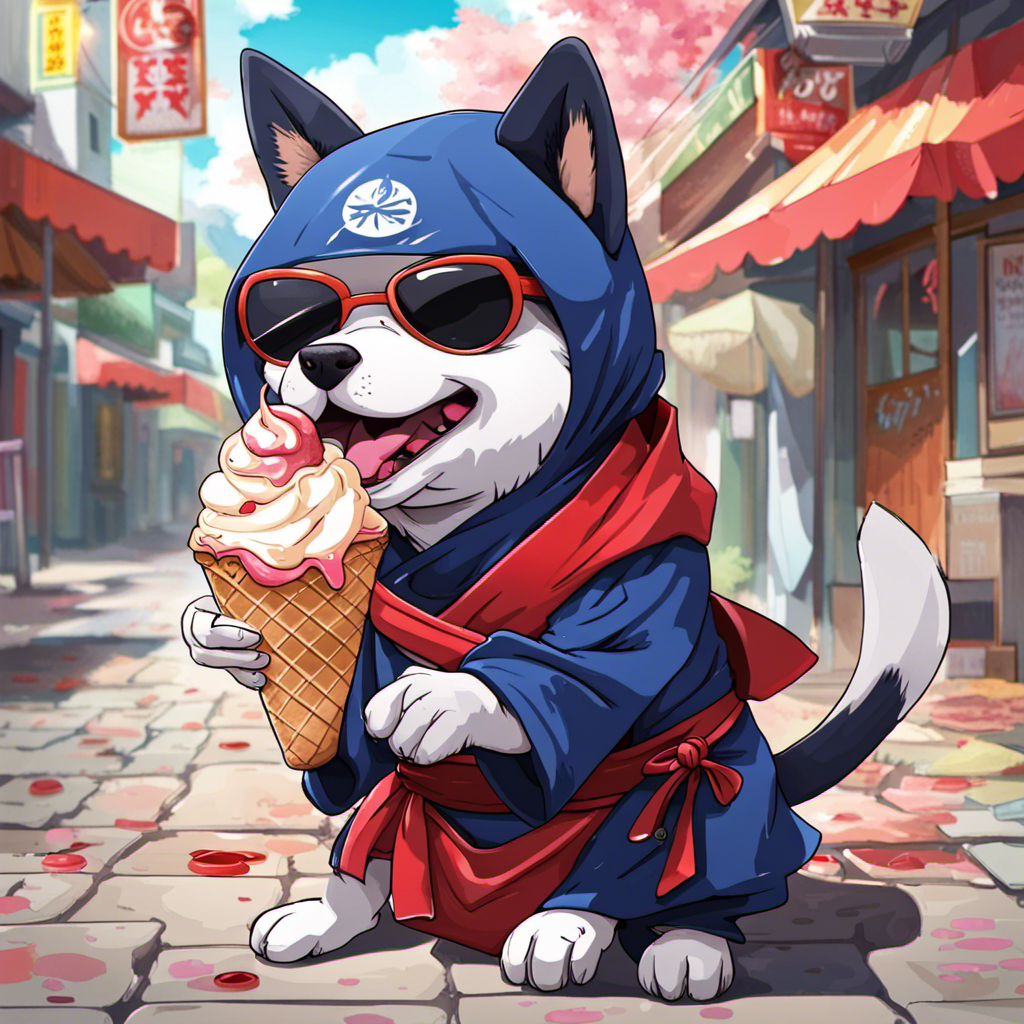

In [47]:
decode_and_show(output)

## <a id='toc4_2_'></a>[B: Image to image](#toc0_)

To perform inference that takes an image as input, you must pass the image into `init_image` as a base64-encoded string. Like output images, input images must be one of the supported resolutions: i.e. (height, width) should be one of   (1024, 1024), (1152, 896), (896, 1152), (1216, 832), (832, 1216), (1344, 768), (768, 1344), (1536, 640), (640, 1536).


Below is a helper function for converting images to base64-encoded strings:

In [48]:
def encode_image(image_path: str, resize: bool = False, size: Tuple[int, int] = (1024, 1024)) -> Union[str, None]:
    """
    Encode an image as a base64 string, optionally resizing it to a supported resolution.

    Args:
        image_path (str): The path to the image file.
        resize (bool, optional): Whether to resize the image. Defaults to True.

    Returns:
        Union[str, None]: The encoded image as a string, or None if encoding failed.
    """
    assert os.path.exists(image_path)
    image = Image.open(image_path)

    if resize:
        image = Image.open(image_path)
        image = image.resize(size)
        updated_image_path = "resize-{}".format(image_path)       
        image.save(updated_image_path)
        image_path = updated_image_path

    assert image.size == size
    with open(image_path, "rb") as image_file:
        img_byte_array = image_file.read()
        # Encode the byte array as a Base64 string
        try:
            base64_str = base64.b64encode(img_byte_array).decode("utf-8")
            return base64_str
        except Exception as e:
            print(f"Failed to encode image {image_path} as base64 string.")
            print(e)
            return None

Let's feed an image into the model as well as the prompt this time. We can set `image_scale` to weight the relative importance of the image and the prompt. 

# Style Transfer Example

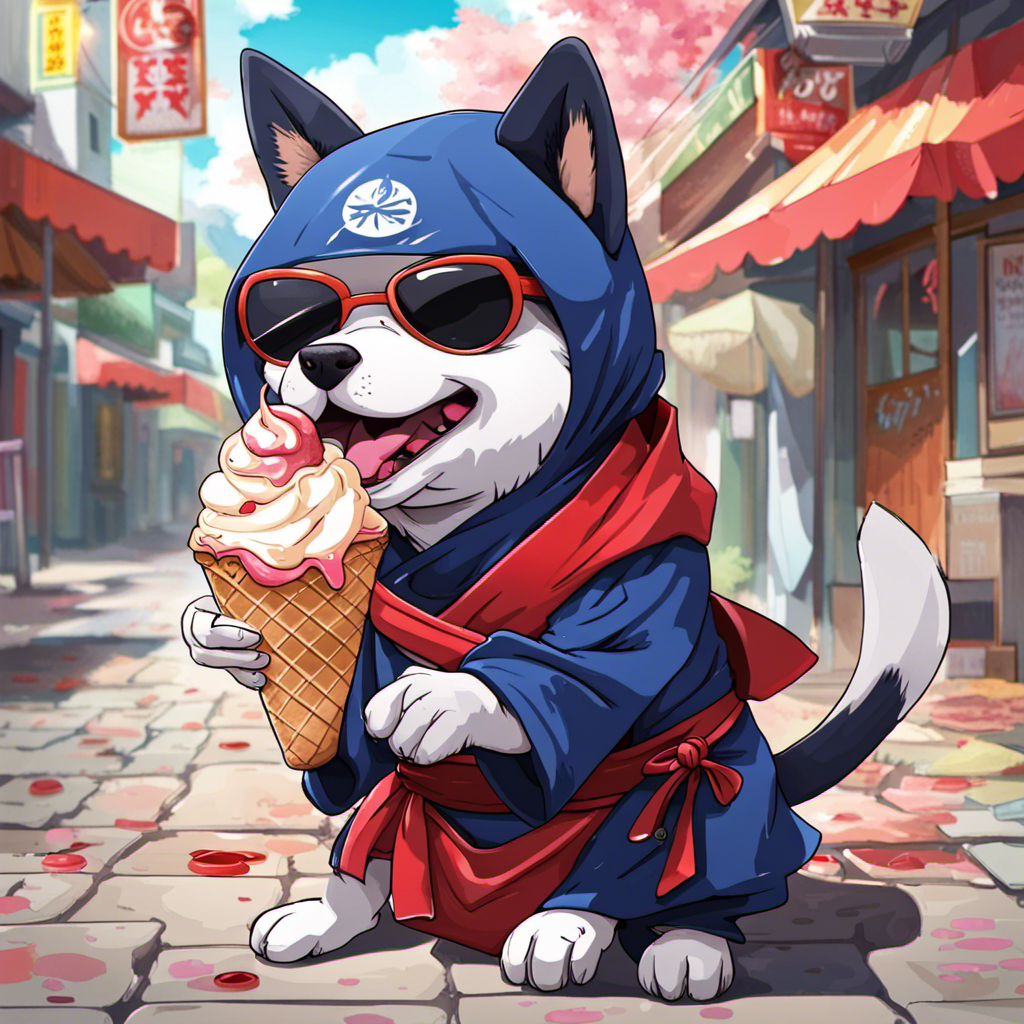

In [50]:
# Here is the original image:
display(Image.open(image_name))

In [51]:
size = (1024,1024)
image_data = encode_image(image_name, size=size)

In [52]:
new_prompt="Create a photograph of a dog dressed as a ninja eating ice cream"

In [ ]:
new_image_name = "{}.png".format(new_prompt.replace(" ", "_"))
new_image_name

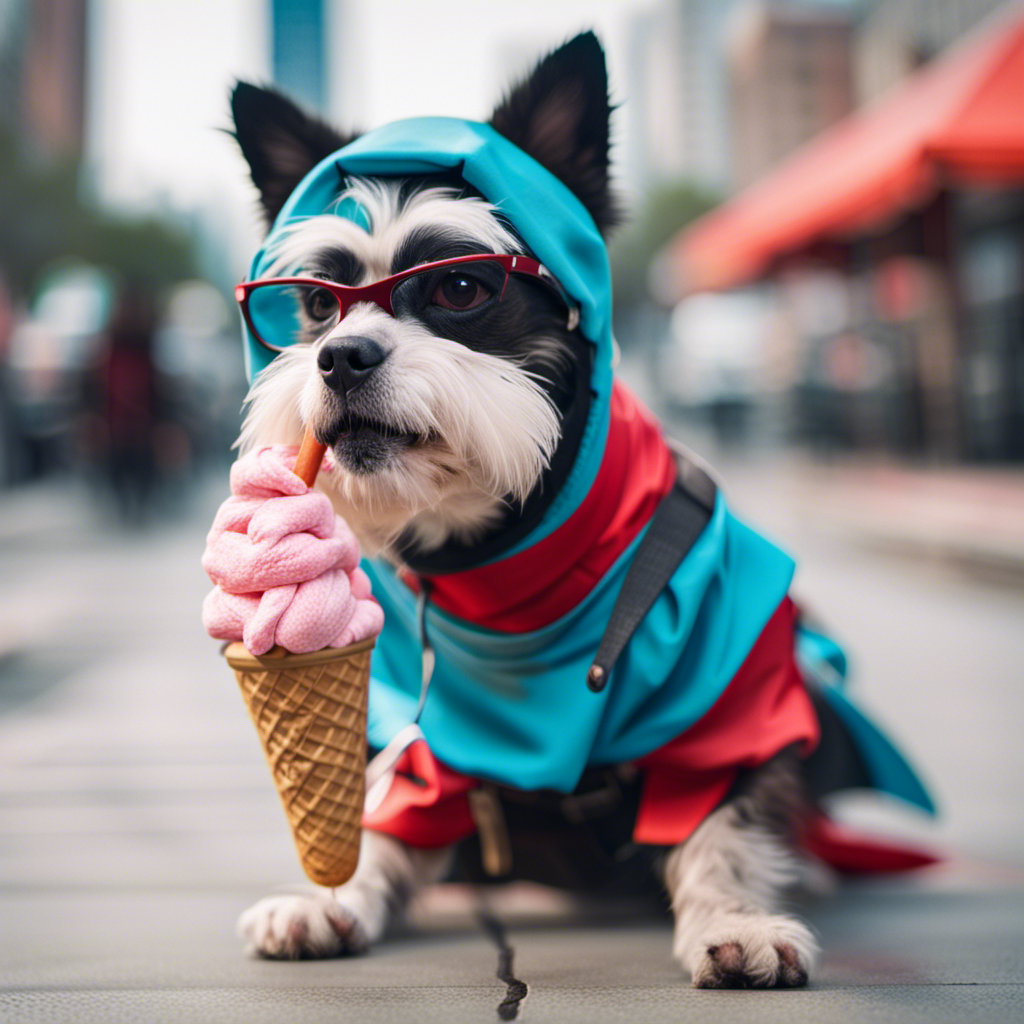

In [53]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=new_prompt)],
        init_image= image_data,
        style_preset="photographic",
        cfg_scale=7,
        image_strength=0.1,
        seed=42,
        height=size[0],
        width=size[1],
        init_image_mode="IMAGE_STRENGTH"
    )
)
decode_and_show(output)

# <a id='toc5_'></a>[3: Delete the endpoint](#toc0_)

When you've finished working, you can delete the endpoint to release the EC2 instance(s) associated with it, and stop billing.

Get your list of Sagemaker endpoints using the AWS Sagemaker CLI like this:

In [ ]:
!aws sagemaker list-endpoints

# Delete an endpoint

In [ ]:
# deployed_model.sagemaker_session.delete_endpoint(endpoint_name)
# # Rerun the aws cli command above to confirm that its gone.